In [ ]:
!kaggle datasets download -d soumikrakshit/lol-dataset
!unzip lol-dataset.zip -d lol_dataset


Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/lol-dataset
License(s): unknown
 99% 327M/331M [00:03<00:00, 76.1MB/s]
100% 331M/331M [00:03<00:00, 93.0MB/s]
Archive:  lol-dataset.zip
  inflating: lol_dataset/lol_dataset/eval15/high/1.png  
  inflating: lol_dataset/lol_dataset/eval15/high/111.png  
  inflating: lol_dataset/lol_dataset/eval15/high/146.png  
  inflating: lol_dataset/lol_dataset/eval15/high/179.png  
  inflating: lol_dataset/lol_dataset/eval15/high/22.png  
  inflating: lol_dataset/lol_dataset/eval15/high/23.png  
  inflating: lol_dataset/lol_dataset/eval15/high/493.png  
  inflating: lol_dataset/lol_dataset/eval15/high/547.png  
  inflating: lol_dataset/lol_dataset/eval15/high/55.png  
  inflating: lol_dataset/lol_dataset/eval15/high/665.png  
  inflating: lol_dataset/lol_dataset/eval15/high/669.png  
  inflating: lol_dataset/lol_dataset/eval15/high/748.png  
  inflating: lol_dataset/lol_dataset/eval15/high/778.png  
  inflating: lol_dataset/lol_dataset/eval15

In [ ]:
import os
import cv2
import numpy as np

low_light_dir = '/content/lol_dataset/lol_dataset/our485/low'
bright_light_dir = '/content/lol_dataset/lol_dataset/our485/high'

low_light_images = sorted(os.listdir(low_light_dir))
bright_light_images = sorted(os.listdir(bright_light_dir))

def load_images(image_list, folder_path, target_size=(256, 256)):
    images = []
    for img_name in image_list:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size) / 255.0
        images.append(img)
    return np.array(images)

X_train = load_images(low_light_images, low_light_dir)
Y_train = load_images(bright_light_images, bright_light_dir)

print(f"Loaded {len(X_train)} low-light images and {len(Y_train)} bright images.")

Loaded 485 low-light images and 485 bright images.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

tf.keras.mixed_precision.set_global_policy('mixed_float16')

def simplified_mirnet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    down1 = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(down1)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    down2 = layers.MaxPooling2D((2, 2), padding='same')(x)


    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(down2)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)


    up1 = layers.UpSampling2D((2, 2))(x)


    down2_resized = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(down2)


    down2_resized = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(down2_resized)

    up1 = layers.Concatenate()([up1, down2_resized])

    up2 = layers.UpSampling2D((2, 2))(up1)


    down1_resized = layers.Conv2D(64 + 128, (3, 3), activation='relu', padding='same')(down1)

    down1_resized = layers.Conv2DTranspose(64+128, (3, 3), strides=(2, 2), padding='same')(down1_resized)

    up2 = layers.Concatenate()([up2, down1_resized])


    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)


    model = models.Model(inputs, outputs)
    return model


model = simplified_mirnet()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 128)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 192)  │         55,488 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 256)  │              0 │ concatenate[0][0]      │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1   

 Total params: 908,003 (3.46 MB)

 Trainable params: 908,003 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=8,
    shuffle=True,
)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 112s 790ms/step - loss: 0.0405 - mae: 0.1654 - val_loss: 0.0368 - val_mae: 0.1527
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - loss: 0.0350 - mae: 0.1537 - val_loss: 0.0268 - val_mae: 0.1337
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0296 - mae: 0.1400 - val_loss: 0.0254 - val_mae: 0.1316
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0279 - mae: 0.1345 - val_loss: 0.0258 - val_mae: 0.1314
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0249 - mae: 0.1265 - val_loss: 0.0261 - val_mae: 0.1270
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0239 - mae: 0.1234 - val_loss: 0.0270 - val_mae: 0.1372
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0257 - mae: 0.1310 - val_loss: 0.0236 - val_mae: 0.1240
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0231 - mae: 0.1224 - val_loss: 0.0250 - val_mae: 0.1296
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0

In [ ]:

model.save('low_light_enhancement_model.h5')

In [ ]:
loss, acc = model.evaluate(X_train[:int(len(X_train)*0.1)], Y_train[:int(len(Y_train)*0.1)])
print(f"Validation Accuracy: {acc*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 14s/step - loss: 0.0213 - mae: 0.1190
Validation Accuracy: 11.86%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


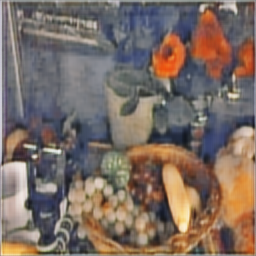

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np


def enhance_image(image_path, model):
    img = cv2.imread("/content/dark.jpg")
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    enhanced_img = model.predict(img)[0]
    enhanced_img = (enhanced_img * 255).astype(np.uint8)

    cv2_imshow(enhanced_img)


enhance_image('dark_image.jpg', model)
